Train the fc-siam-diff network on the levir-cd dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (17, 10)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

import tensorflow as tf
import numpy as np
from tools import plot_cm, plot_metrics, plot_roc, plot_prediction

from unet_diff import get_unet_model
from siamese_diff import get_siamese_model

2024-06-19 14:29:21.743457: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 14:29:21.924855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 14:29:22.631303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Do you want to create the model or load it from file
CREATE_MODEL=True

## Data processing

Download training and validation dataset from https://drive.google.com/file/d/18GuoCuBn48oZKAlEo-LrNwABrFhVALU-/view?usp=sharing

In [3]:
os.path.isfile('train.zip')

True

In [4]:
os.path.isdir('levir_dataset')

True

In [62]:
os.path.isfile('val.zip')

True

In [63]:
os.path.isdir('val')

True

In [5]:
BATCH_SIZE = 4
height = 224
width=224

In [6]:
def map_filename_to_image_and_mask(t1_filename,t2_filename, a_filename, height=height, width=width):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t1_filename (string) -- path to the first raw input image
    t2_filename (string) -- path to the second raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors
  img1_raw = tf.io.read_file(t1_filename)
  img2_raw = tf.io.read_file(t2_filename)
  anno_raw = tf.io.read_file(a_filename)
  image1 = tf.image.decode_jpeg(img1_raw)
  image2 = tf.image.decode_jpeg(img2_raw)
  annotation = tf.image.decode_jpeg(anno_raw)

  # Resize image and segmentation mask
  image1 = tf.image.resize(image1, (height, width,))
  image2 = tf.image.resize(image2, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image1 = tf.reshape(image1, (height, width, 3,))
  image2 = tf.reshape(image2, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

   # # Normalize pixels in the input image
  image1 = image1/255
  image2 = image2/255
  import math
  annotation = tf.math.round(annotation/255)
  
  return (image1, image2),  annotation

In [7]:
def get_dataset_slice_paths(image1_dir, image2_dir, label_map_dir, lim=None):
  '''
  generates the lists of image and label map paths

  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image1_file_list = os.listdir(image1_dir)
  image2_file_list = os.listdir(image2_dir)
  label_map_file_list = os.listdir(label_map_dir)
    
  image1_paths = [os.path.join(image1_dir, fname) for fname in image1_file_list]
  image2_paths = [os.path.join(image2_dir, fname) for fname in image2_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  if lim==None:
      return image1_paths, image2_paths, label_map_paths
  else:
      return image1_paths[:lim], image2_paths[:lim], label_map_paths[:lim]


def get_training_dataset(image1_paths, image2_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.

  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image1_paths, image2_paths,  label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset

def get_validation_dataset(image1_paths, image2_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.

  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image1_paths, image2_paths,  label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)

  return validation_dataset

In [8]:
# get the paths to the images
training_image1_paths, training_image2_paths, training_label_map_paths = get_dataset_slice_paths('levir_dataset_full/A','levir_dataset_full/B', 'levir_dataset_full/label', lim=200)
validation_image1_paths, validation_image2_paths, validation_label_map_paths = get_dataset_slice_paths('val_full/A','val_full/B', 'val_full/label', lim=50)

# generate the train and val sets
training_dataset = get_training_dataset(training_image1_paths, training_image2_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image1_paths, validation_image2_paths, validation_label_map_paths)


### Check distribution of training images


In [9]:
from math import ceil

def plot_imgs(*imgs):
    plt.figure(figsize=(17, 10))
    i=1
    for img in imgs:
        plt.subplot(1, len(imgs), i)
        plt.imshow(img)
        i+=1



In [10]:
for i,l in training_dataset.take(10):
    im1=i[0]
    im2=i[1]
    lb=l
    break

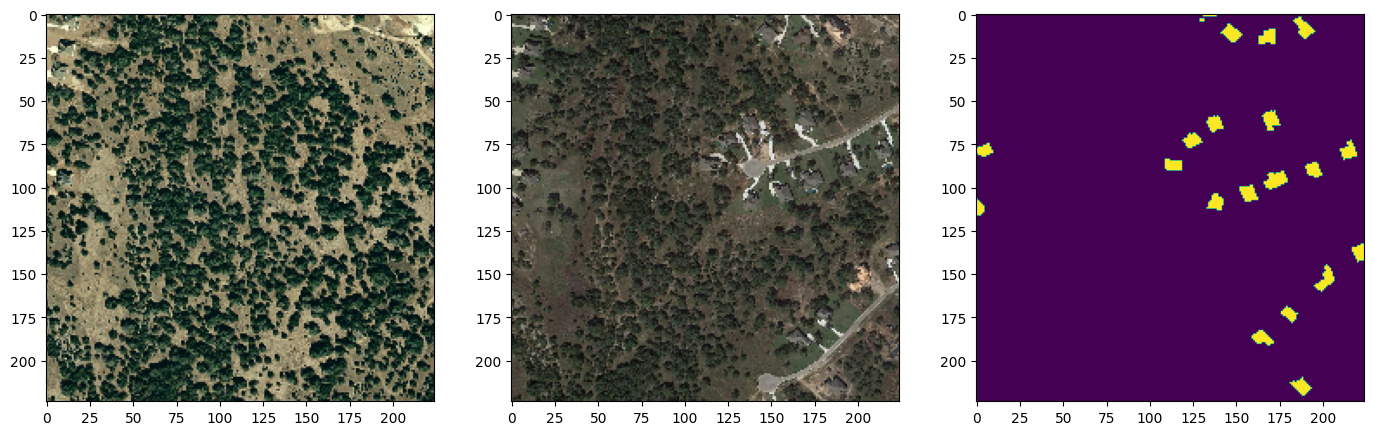

In [11]:
index=0
plot_imgs(im1[index], im2[index], lb[index])


0.0 - 1.0
0.004622498527169228 - 0.9880958795547485
0.0 - 1.0


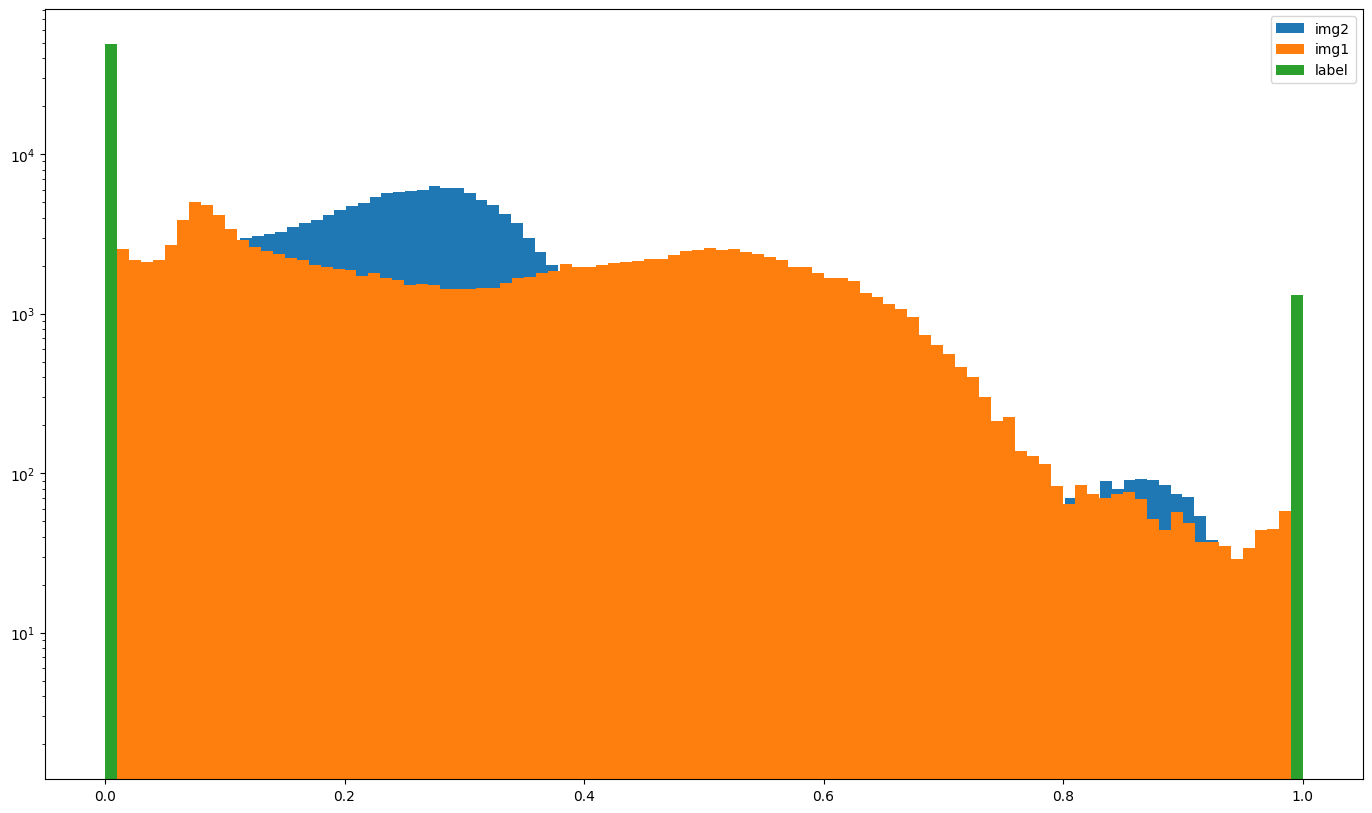

In [12]:
im1_1d = np.reshape(im1[0], im1[0].shape[0]*im1[0].shape[1]*im1[0].shape[2])
im2_1d = np.reshape(im2[0], im2[0].shape[0]*im2[0].shape[1]*im2[0].shape[2])
label_1d = np.reshape(lb[0], lb.shape[1]*lb.shape[2])
plt.hist(im2_1d, bins=100, label='img2')
plt.hist(im1_1d, bins=100, label='img1')
plt.hist(label_1d, bins=100, label='label')
plt.yscale("log")
plt.legend()

print(f'{np.min(im1_1d)} - {np.max(im1_1d)}')
print(f'{np.min(im2_1d)} - {np.max(im2_1d)}')
print(f'{np.min(label_1d)} - {np.max(label_1d)}')

### Check distribution of validation images


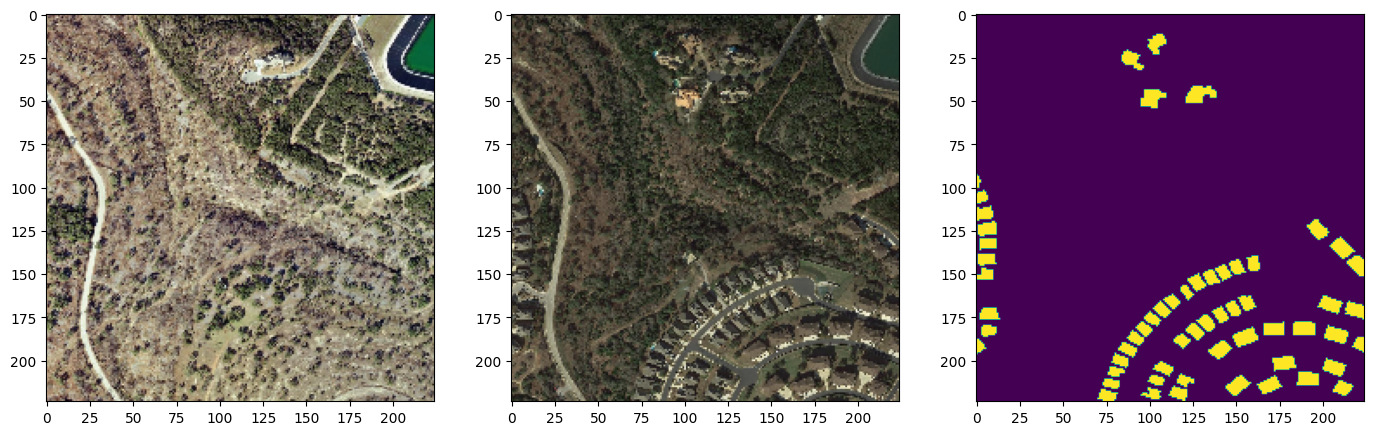

In [13]:
for i,l in validation_dataset.take(1):
    imv1=i[0]
    imv2=i[1]
    lbv=l
    break

index=0
plot_imgs(imv1[index], imv2[index], lbv[index])

0.0 - 0.9959383010864258
0.0 - 0.9981186985969543
0.0 - 1.0


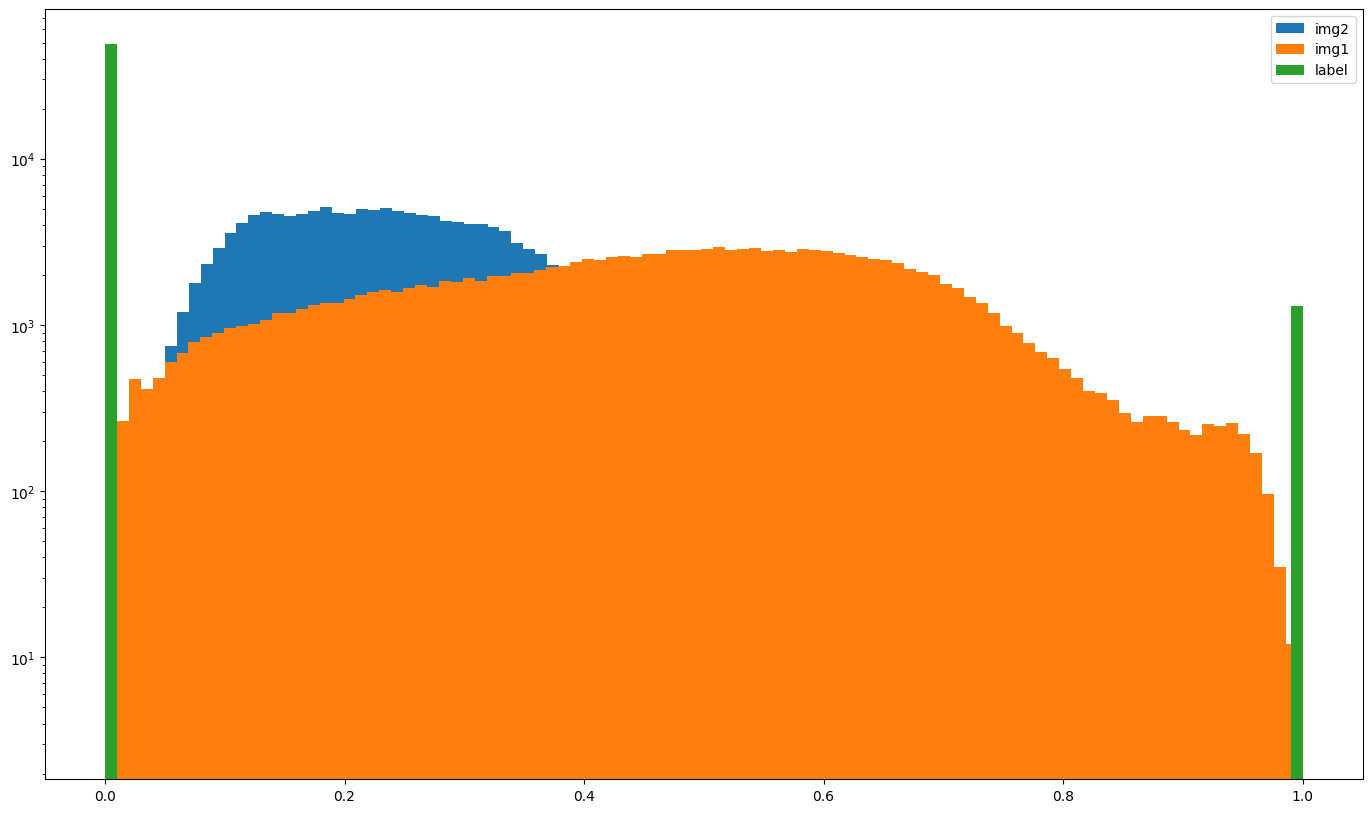

In [14]:
im1_1d = np.reshape(imv1[0], imv1[0].shape[0]*imv1[0].shape[1]*imv1[0].shape[2])
im2_1d = np.reshape(imv2[0], imv2[0].shape[0]*imv2[0].shape[1]*imv2[0].shape[2])
label_1d = np.reshape(lb[0], lb.shape[1]*lb.shape[2])
plt.hist(im2_1d, bins=100, label='img2')
plt.hist(im1_1d, bins=100, label='img1')
plt.hist(label_1d, bins=100, label='label')
plt.yscale("log")
plt.legend()

print(f'{np.min(im1_1d)} - {np.max(im1_1d)}')
print(f'{np.min(im2_1d)} - {np.max(im2_1d)}')
print(f'{np.min(label_1d)} - {np.max(label_1d)}')

### Get categories weight
The paper says that "The two classes (change and no
change) were assigned weights inversely proportional to the
number of examples in each one"

Let's compute the weights for each class on the train sample

In [15]:
one_counts=0
zero_counts=0
n_images=0
for i,l in training_dataset.take(100):
    for i in lb:
        one_counts += np.argwhere(i!=0).shape[0]
        zero_counts += np.argwhere(i==0).shape[0]
        n_images += 1
    lb=l


ONE_WEIGHT = one_counts #/ n_images
ZERO_WEIGHT = zero_counts #/ n_images

# Class weights are computing according to https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
label_classes_weight = {0:(ZERO_WEIGHT+ONE_WEIGHT)/(2*ZERO_WEIGHT), 1: (ZERO_WEIGHT+ONE_WEIGHT)/(2*ONE_WEIGHT)}
print(label_classes_weight)

{0: 0.5223375939824577, 1: 11.691894713295056}


2024-06-19 14:29:26.588335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Get model

In [16]:
# model = get_unet_model(height)
model = get_siamese_model(height)

In [17]:
#model.summary()

In [18]:
# We define a learning rate scheduler similar to that in the original paper
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.0005
)

In [19]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

## Train model

In [42]:
model = get_siamese_model(height)
optim = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optim, 
              metrics=METRICS, 
              loss = loss,)


if CREATE_MODEL:
    history = model.fit(training_dataset, 
                                         validation_data = validation_dataset, 
                                         epochs=50, 
                                         callbacks=[reduce_lr], 
                                         class_weight=label_classes_weight)
    model.save_weights('model.weights.h5')
else:
    model.load_weights('model.weights.h5')



Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 348ms/step - Brier score: 0.1745 - accuracy: 0.7262 - auc: 0.8436 - cross entropy: 0.5342 - fn: 65303.1953 - fp: 2063369.8750 - loss: 0.5878 - prc: 0.2510 - precision: 0.1161 - recall: 0.7976 - tn: 5329884.5000 - tp: 264610.8750 - val_Brier score: 0.3368 - val_accuracy: 0.5253 - val_auc: 0.7580 - val_cross entropy: 5.0276 - val_fn: 15228.0000 - val_fp: 1175792.0000 - val_loss: 5.0276 - val_prc: 0.1130 - val_precision: 0.0769 - val_recall: 0.8655 - val_tn: 1219814.0000 - val_tp: 97966.0000 - learning_rate: 0.0100
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 329ms/step - Brier score: 0.1542 - accuracy: 0.7592 - auc: 0.8985 - cross entropy: 0.4610 - fn: 27634.1367 - fp: 1211870.2500 - loss: 0.4121 - prc: 0.3174 - precision: 0.1436 - recall: 0.8832 - tn: 3769068.0000 - tp: 205796.2188 - val_Brier score: 0.4542 - val_accuracy: 0.4465 - val_auc: 0.7919 - val_cross entropy: 2.2944 - val_fn: 3239.0000 - val_fp: 1385277.0000 - val_loss: 2.2944 - val_prc: 0

### Computing some metrics

In [43]:
validation_predictions = model.predict(validation_dataset, batch_size=BATCH_SIZE)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


In [44]:
validation_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

2024-06-19 15:43:49.778752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Confusion Matrix with default threshold of 0.5

Legitimate Transactions Detected (True Negatives):  2373375
Legitimate Transactions Incorrectly Detected (False Positives):  22231
Fraudulent Transactions Missed (False Negatives):  56770
Fraudulent Transactions Detected (True Positives):  56424
Total Fraudulent Transactions:  113194


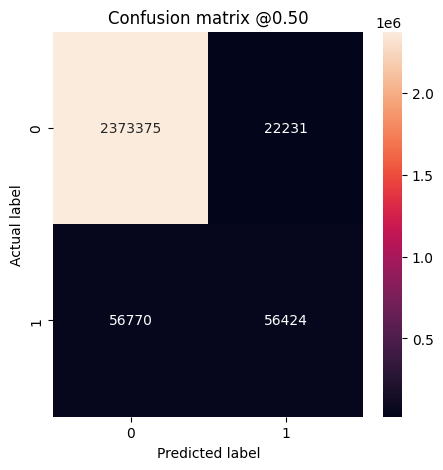

In [45]:
validation_predictions_1d = np.reshape(validation_predictions, (validation_predictions.shape[0]*validation_predictions.shape[1]*validation_predictions.shape[2]))
validation_labels_1d = np.reshape(validation_labels, (validation_labels.shape[0]*validation_labels.shape[1]*validation_labels.shape[2]))
plot_cm(validation_labels_1d, validation_predictions_1d)

#### F1, Precision and Recall

In [46]:
f1 = sklearn.metrics.f1_score(validation_labels_1d, np.where(validation_predictions_1d>0.5,1,0))
precision = sklearn.metrics.precision_score(validation_labels_1d, np.where(validation_predictions_1d>0.5,1,0))
recall = sklearn.metrics.recall_score(validation_labels_1d, np.where(validation_predictions_1d>0.5,1,0))

print(f'f1 - {f1}')
print(f'precision - {precision}')
print(f'recall - {recall}')

f1 - 0.5882126047047418
precision - 0.717360625516496
recall - 0.4984716504408361


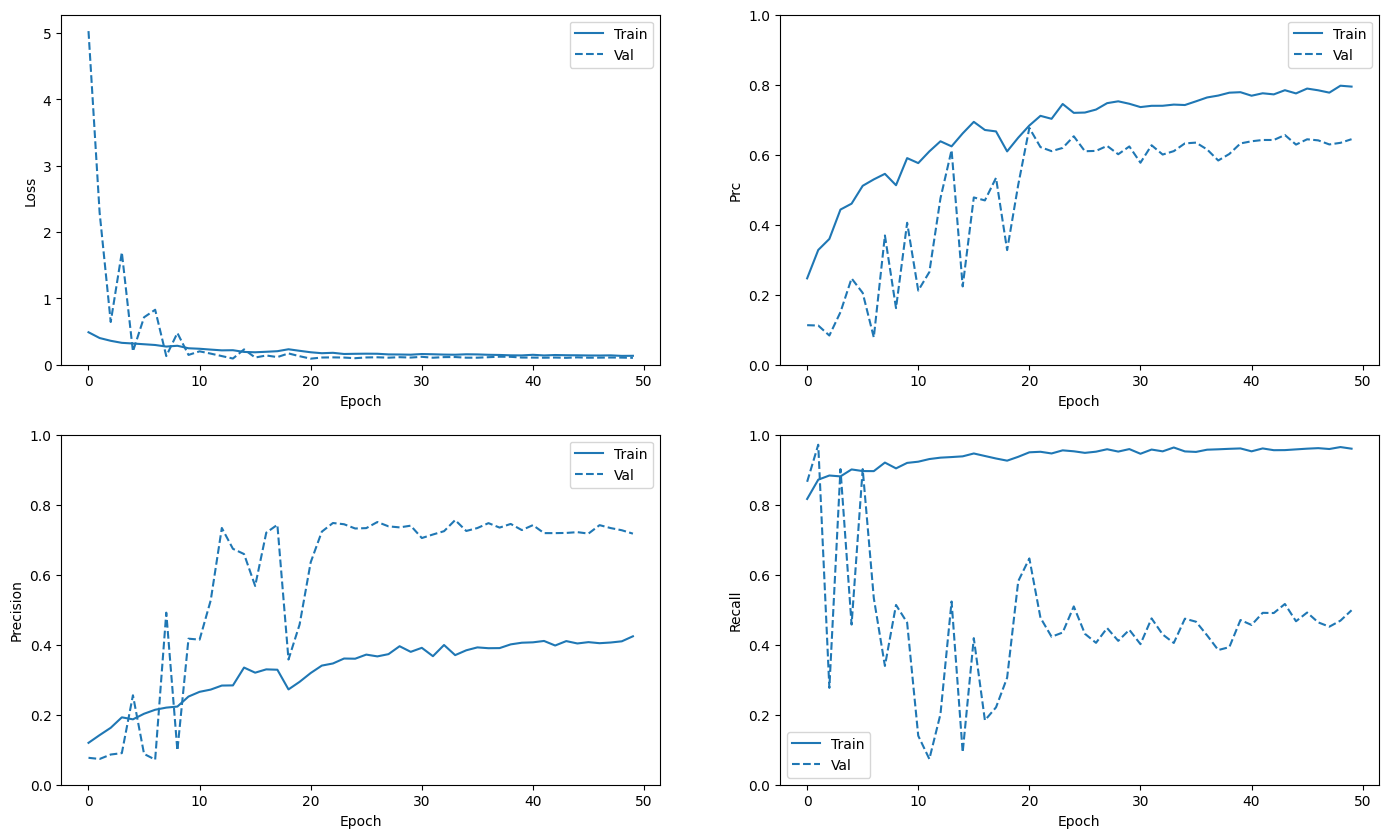

In [48]:
plot_metrics(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


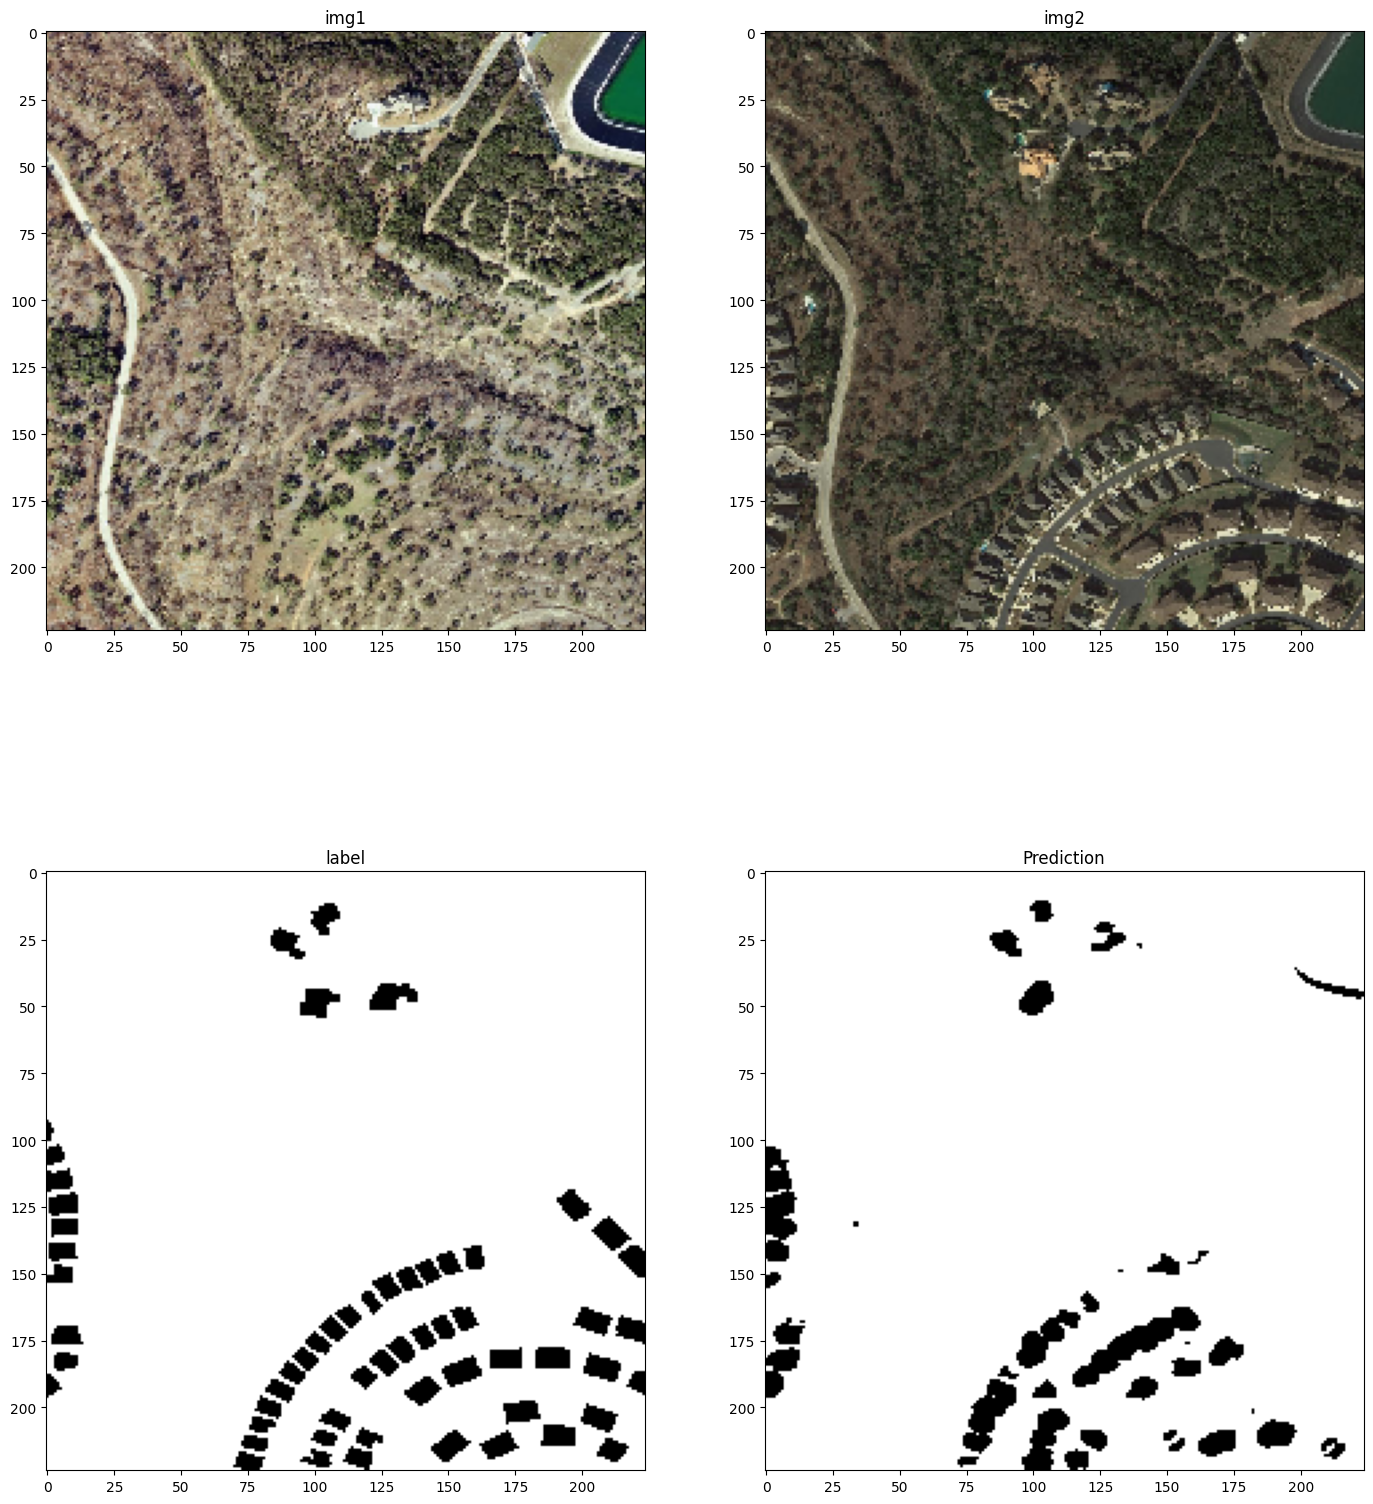

In [49]:
plot_prediction(model_weight_loss, validation_dataset)

### Fine tune Threshold parameter

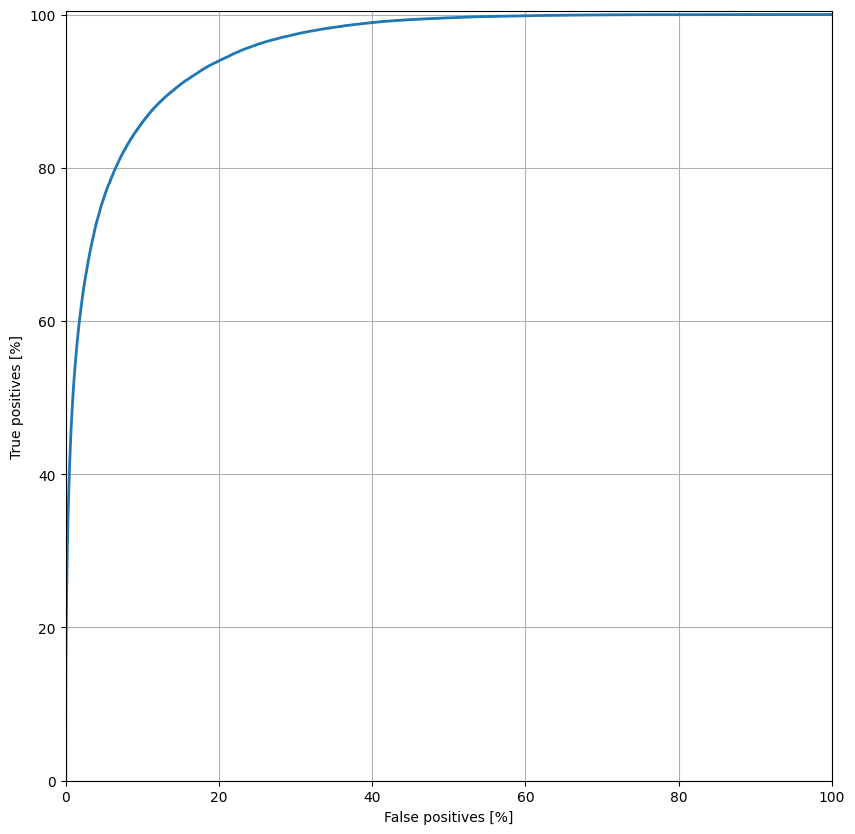

In [50]:
fp_weight, tp_weight, threshold_weight = plot_roc("Train Baseline", validation_labels_1d, validation_predictions_1d, color=colors[0])


It seems that the model using weighted loss function is performing better

It seems that chosing a threshold such that TP is around 90% would be a good trade off.
Let's check for the trade-off value

In [56]:
df = pd.DataFrame({'fp':fp_weight, 'tp': tp_weight, 'threshold':threshold_weight})

In [57]:
df[ (0.90 < df['tp']) & (df['tp'] < 0.901) ].head()

fp        tp  threshold
110364  0.138972  0.900004   0.004985
110365  0.138974  0.900004   0.004984
110366  0.138974  0.900012   0.004984
110367  0.138987  0.900012   0.004984
110368  0.138988  0.900012   0.004984

We can set the threshold to 0.2


In [58]:
THRESHOLD = 0.32

## Make predictions with new threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


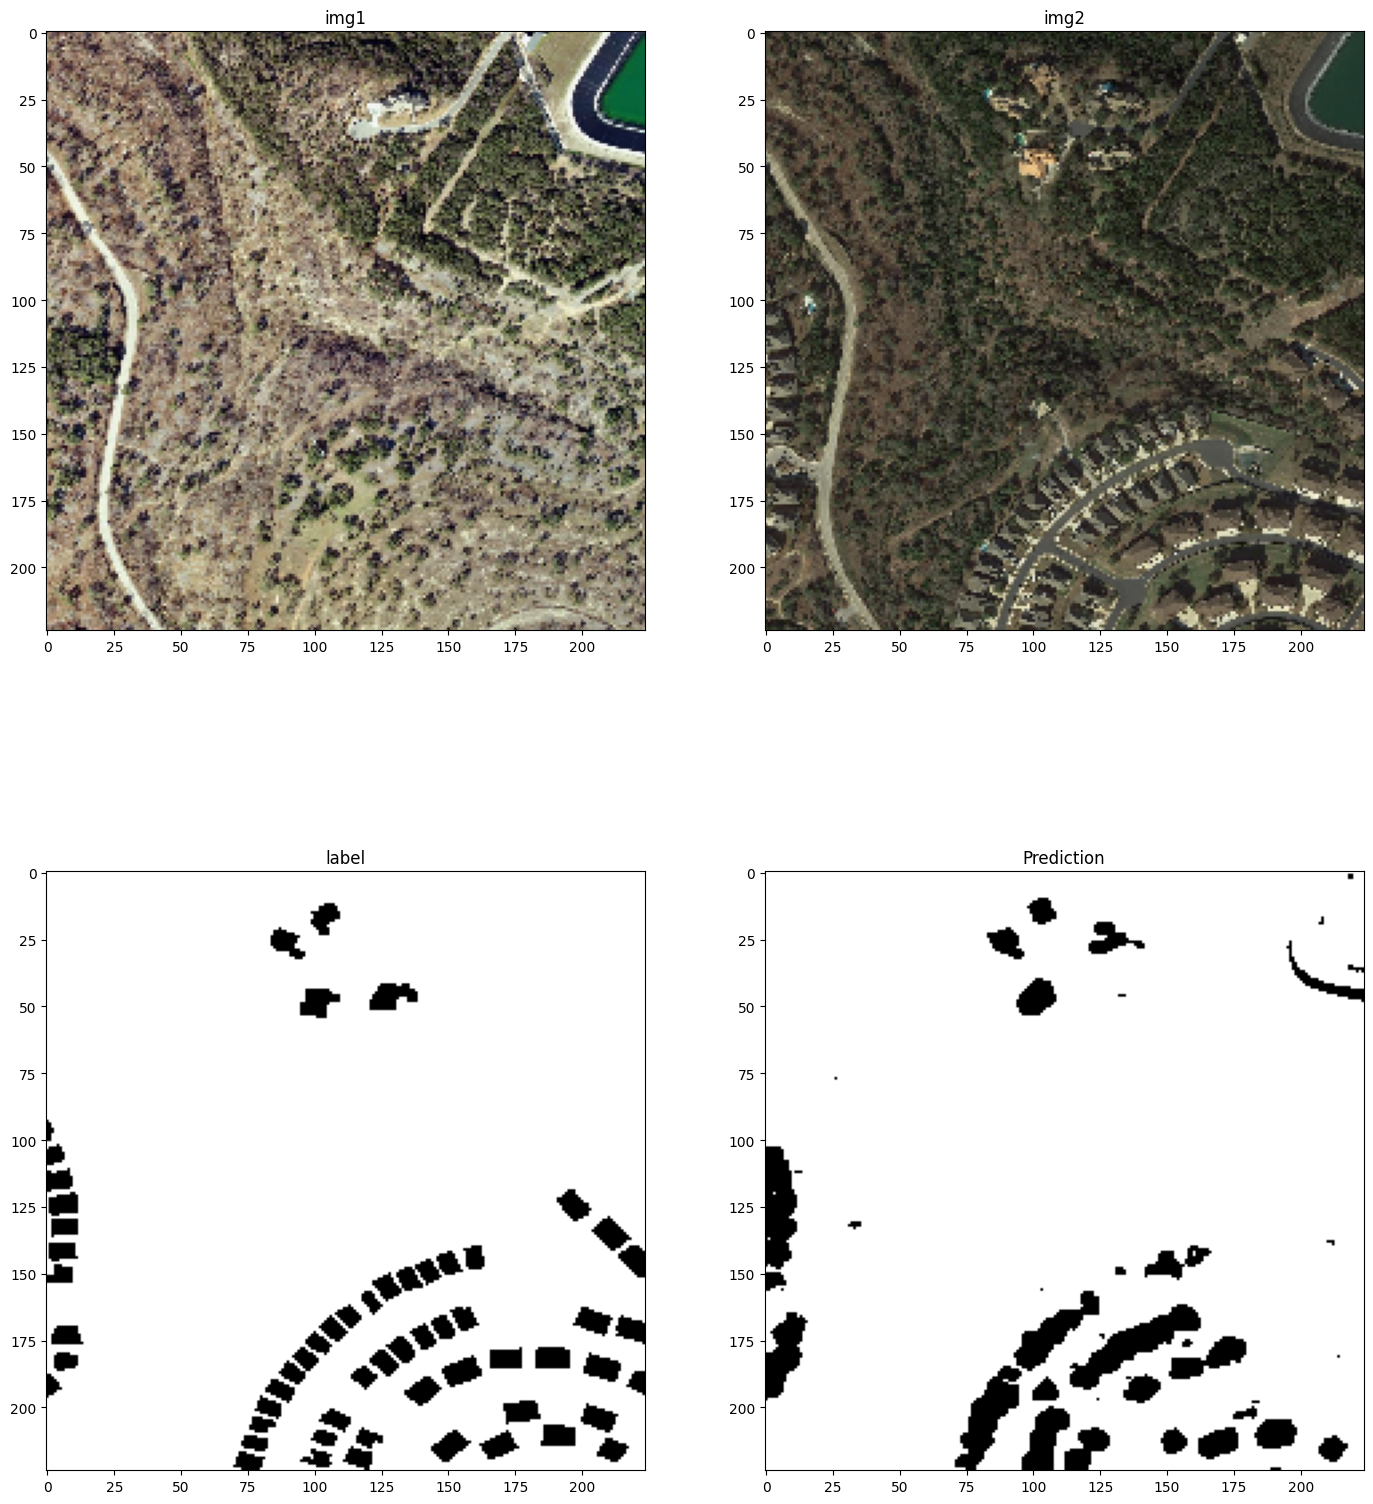

In [59]:
plot_prediction(model_weight_loss, validation_dataset, threshold=THRESHOLD)

In [60]:
f1_thres = sklearn.metrics.f1_score(validation_labels_1d, np.where(validation_predictions_1d>THRESHOLD,1,0))
precision_thres = sklearn.metrics.precision_score(validation_labels_1d, np.where(validation_predictions_1d>THRESHOLD,1,0))
recall_thres = sklearn.metrics.recall_score(validation_labels_1d, np.where(validation_predictions_1d>THRESHOLD,1,0))

print(f'f1 - {f1_thres}')
print(f'precision - {precision_thres}')
print(f'recall - {recall_thres}')

f1 - 0.6046762029345512
precision - 0.6495703081403017
recall - 0.5655865151863173


### Check metrics w.r.t former threshold

In [61]:
print(f'f1 - {f1} - {f1_thres}')
print(f'precision - {precision} - {precision_thres}')
print(f'recall - {recall} - {recall_thres}')

f1 - 0.5882126047047418 - 0.6046762029345512
precision - 0.717360625516496 - 0.6495703081403017
recall - 0.4984716504408361 - 0.5655865151863173


After threshold:
* F1 slightly higher -> Models might perform slightly better overall
* Precision is lower -> more false positives
* Recal is higher -> model detects more true values (less false negatives)